# Packages

### install packages

In [1]:
# !pip install matplotlib
# !pip install torch
# !pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### import packages

In [2]:
import os
import json
from dataclasses import dataclass

import torch
from torch import nn
import torchmetrics

from matplotlib import pyplot as plt

%matplotlib inline

# Prepare Dataset

### Upload Tokenized tweets and labels

In [3]:
data_folder = 'sample_data'
data_folder = os.path.join(os.curdir,data_folder)
stemmed_tweets_path = os.path.join(data_folder,'stemmed_tweets.json')
vocab_path = os.path.join(data_folder,'vocabs.json')
tokenization_path = os.path.join(data_folder,'tokenization_matrix.json')
stemmed_tweets = {}
vocabs = {}
tokenization_list = {}

with open(stemmed_tweets_path,encoding='utf-8') as f:
  stemmed_tweets = json.load(f)

with open(vocab_path,encoding='utf-8') as f:
  vocabs = json.load(f)

with open(tokenization_path, 'r') as f:
  tokenization_list = json.load(f)

vocab_to_index = vocabs["vocab_to_index"]

y_train = stemmed_tweets["train_output"]
y_test = stemmed_tweets["test_output"]

tokenization_matrix = tokenization_list['tokenization_matrix']
x_test = tokenization_list['test_data_tokenization_matrix']
x_train = tokenization_list['train_data_tokenization_matrix']

### prepare torch dataloader

In [4]:
batch_size = 16
# convert 'pos' to [0,1] and 'neg' to [1,0] 
y_train = [[1,0] if word == 'neg' else [0,1] for word in y_train]
y_test = [[1,0] if word == 'neg' else [0,1] for word in y_test]
# datasets
train_dataset = torch.utils.data.TensorDataset(torch.tensor(x_train),torch.tensor(y_train))
test_dataset = torch.utils.data.TensorDataset(torch.tensor(x_test),torch.tensor(y_test))
# dataloader
train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

# Model

In [5]:
class SentimentAnalyzer(nn.Module):

  def __init__(
      self, 
      embedding_size:int, 
      embedding_dim:int, 
      padding_idx:int, 
      OOV_idx:int,
      hidden_size:int, 
      num_layers:int,
      dropout:float,
      output_dim:int, 
  ):

    super().__init__()

    self.embeddings = nn.Embedding(
        num_embeddings=embedding_size, 
        embedding_dim=embedding_dim,
        padding_idx=padding_idx,
        max_norm=1.0,
    )

    self.embeddings.weight.data[OOV_idx] = torch.zeros(embedding_dim)
    
    self.rnn = nn.LSTM(
        input_size=embedding_dim,
        hidden_size=hidden_size,
        num_layers=num_layers,
        batch_first=True,
        bidirectional=True,
        dropout=dropout
    )

    self.dropout_layer = nn.Dropout(dropout)

    self.fc1 = nn.Linear(in_features=hidden_size * 2,out_features=hidden_size)

    self.fc2 = nn.Linear(in_features=hidden_size,out_features=output_dim)

  def forward(self,x):
    embeddings = self.embeddings(x)
    embeddings = self.dropout_layer(embeddings)
    output_states,(last_hidden_state,last_cell_state) = self.rnn(embeddings)
    output = self.dropout_layer(torch.cat([last_hidden_state[-2],last_hidden_state[-1]],dim=1))
    output = torch.relu(self.fc1(output))
    output = self.fc2(output)
    return output

# Training

### training setup

##### variables defintion

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
embedding_size = len(vocab_to_index)
embedding_dim = 100
padding_idx = 0
OOV_idx = 1
hidden_size = 32
num_layers = 1
dropout = 0.5
output_dim = 2
epochs = 15

##### model

In [7]:
model = SentimentAnalyzer(
      embedding_size=embedding_size, 
      embedding_dim=embedding_dim, 
      padding_idx=padding_idx, 
      OOV_idx=OOV_idx,
      hidden_size=hidden_size, 
      num_layers=num_layers,
      dropout=dropout,
      output_dim=output_dim, 
).to(device)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


##### optim, loss and metric functions

In [8]:
# optim function
optim = torch.optim.Adam(params=model.parameters(), lr=1e-4)
# loss function
criterion = nn.CrossEntropyLoss()
# metric functions
train_metric = torchmetrics.F1Score(num_classes=2).to(device)
val_metric = torchmetrics.F1Score(num_classes=2).to(device)

##### epoch class

In [10]:
@dataclass
class Epoch:
    epoch: int
    training_loss: float
    validation_loss: float
    training_acc: float
    validation_acc: float
    
    def log(self) -> None:
        print(f"Epoch {self.epoch + 1}: Training Loss: {self.training_loss}\tValidation Loss: {self.validation_loss} || Training F1: {self.training_acc}\tValidation F1: {self.validation_acc}")

### trainnig 

In [11]:
history = []
for epoch in range(epochs):
  train_loss = 0
  val_loss = 0
  train_f1 = 0
  val_f1 = 0
  train_metric.reset()
  val_metric.reset()
  model.train()
  for batch in train_dataloader:
    optim.zero_grad()
    input, target = batch
    input, target = input.to(device), target.to(device)
    pred = model(input)
    loss = criterion(pred,target.float())
    train_metric(pred,target)
    loss.backward()
    optim.step()
    train_loss += loss.item()
  train_f1 = round(train_metric.compute().item(),3)
  model.eval()
  with torch.no_grad():
    for batch in test_dataloader:
      input, target = batch
      input, target = input.to(device), target.to(device)
      pred = model(input)
      loss = criterion(pred,target.float())
      val_metric(pred,target)
      val_loss += loss.item()
    val_f1 = round(val_metric.compute().item(),3) 
  train_loss = round(train_loss/len(train_dataloader),3)
  val_loss = round(val_loss/len(test_dataloader),3)
  epoch_result = Epoch(
    epoch=epoch,
    training_loss=train_loss,
    validation_loss=val_loss,
    training_acc=train_f1,
    validation_acc=val_f1,
  )
  history.append(epoch_result)
  epoch_result.log()

Epoch 1: Training Loss: 0.498	Validation Loss: 0.289 || Training F1: 0.511	Validation F1: 0.84
Epoch 2: Training Loss: 0.289	Validation Loss: 0.238 || Training F1: 0.844	Validation F1: 0.883
Epoch 3: Training Loss: 0.242	Validation Loss: 0.212 || Training F1: 0.882	Validation F1: 0.903
Epoch 4: Training Loss: 0.217	Validation Loss: 0.202 || Training F1: 0.899	Validation F1: 0.909
Epoch 5: Training Loss: 0.2	Validation Loss: 0.196 || Training F1: 0.908	Validation F1: 0.916
Epoch 6: Training Loss: 0.186	Validation Loss: 0.196 || Training F1: 0.917	Validation F1: 0.917
Epoch 7: Training Loss: 0.175	Validation Loss: 0.194 || Training F1: 0.922	Validation F1: 0.921
Epoch 8: Training Loss: 0.169	Validation Loss: 0.191 || Training F1: 0.926	Validation F1: 0.921
Epoch 9: Training Loss: 0.161	Validation Loss: 0.194 || Training F1: 0.929	Validation F1: 0.923
Epoch 10: Training Loss: 0.155	Validation Loss: 0.189 || Training F1: 0.933	Validation F1: 0.923
Epoch 11: Training Loss: 0.15	Validation L

### visualization

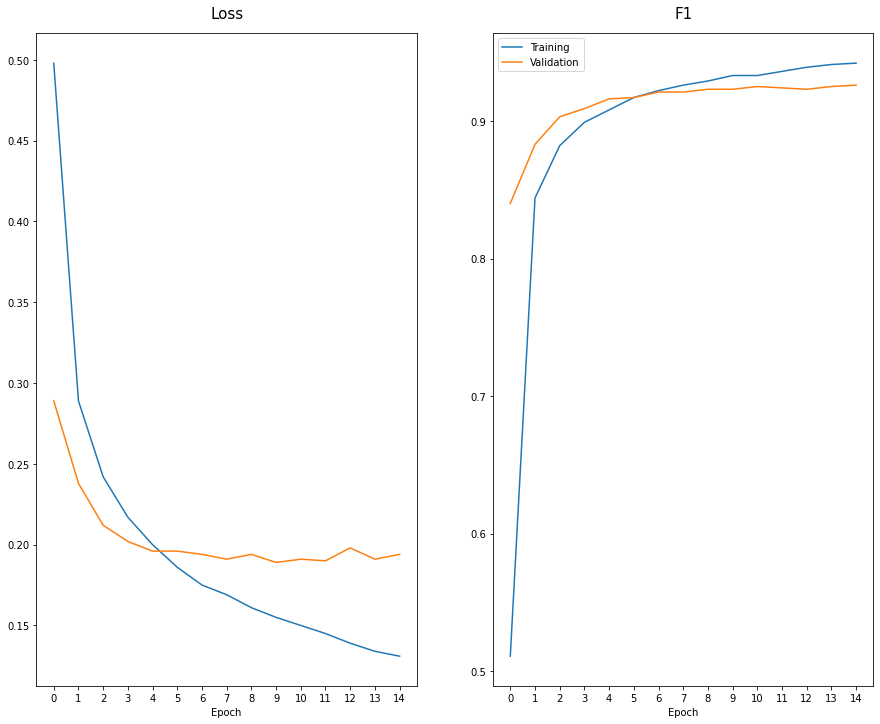

In [12]:
train_loss = list(map(lambda x: x.training_loss ,history))
val_loss = list(map(lambda x: x.validation_loss ,history))
train_acc = list(map(lambda x: x.training_acc, history))
val_acc = list(map(lambda x: x.validation_acc, history))


fig, (ax1, ax2) = plt.subplots(figsize=(15, 12), ncols=2)

ax1.plot(range(epochs), train_loss, label="Training")
ax1.plot(range(epochs), val_loss, label="Validation")

ax2.plot(range(epochs), train_acc, label="Training")
ax2.plot(range(epochs), val_acc, label="Validation")

ax1.set_title("Loss", fontdict=dict(size=15), pad=15)
ax2.set_title("F1", fontdict=dict(size=15), pad=15)

ax1.set_xticks(range(epochs))
ax2.set_xticks(range(epochs))

ax1.set_xlabel("Epoch")
ax2.set_xlabel("Epoch")

plt.legend()
plt.show()